# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import sys
from IPython.display import display
import pprint

import missingno as msno
from googletrans import Translator

import itertools

'''custom modules for convenience'''
# function similar to Excel's vlookup
from vlookup import vlookup
# function to view all contents of a dataframe
from view_all import view_all

# import math
# import nltk
# from nltk.corpus import wordnet

In [2]:
# pip install googletrans==4.0.0-rc1
# pip install missingno
# custom modules for convenience are in root folder

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Load and overview

#### 1.1 azdias

In [3]:
# 제출전 주석 해제
# '''
# load and file structure
# '''

# azdias = pd.read_csv('../csv_pickle/Udacity_AZDIAS_052018.csv', sep=';')
# azdias.name = 'azdias'
# print (azdias.shape)
# azdias.head()

In [4]:
azdias = pd.read_pickle('../csv_pickle/azdias.pickle')
azdias.name = 'azdias'
print (azdias.info())
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


[function] miss_val_overview

In [5]:
def miss_val_overview(df, chunk_size = 100):
    '''
    function to display missing value using missingno(msno) library
    df: dataframe
    chunk_size: size of column chunk, 100 as default  
    '''
    # split df columns into chunks
    chunk_size = chunk_size
    column_chunks = [df.iloc[:, i : i + chunk_size] for i in range(0, df.shape[1], chunk_size)]

    # generate and display missingno plots for each chunk
    for i, _ in enumerate(column_chunks):
        msno.matrix(_, figsize = (10, 3), fontsize = 10, labels = False, sparkline = False)
        plt.title(
            f'missing value overview - column {i * 100} to {min (i * chunk_size + chunk_size - 1, df.shape[1] - 1)}',
            fontsize = 10);

In [6]:
# '''
# missing value overview
# '''

# miss_val_overview(azdias)

[function] miss_val_summary

In [7]:
def miss_val_summary(df, axis_val, x_bin = 2, bar_chart = True):
    '''
    function to display summary, bar-chart (optional) and histogram
    of missing value by column or raw
    df: dataframe
    axis_val: str, one of 'column' or 'row'
    x_bin: size of x bin, 10 as default
    bar_chart: option of bar chart display 
    '''
    # index of axis
    axis_idx = 0 if axis_val == 'column' else 1
    
    # % of missing values
    missing_pct = df.isnull().mean(axis = axis_idx) * 100
    df_desc = missing_pct.describe()

    # summary of missing value
    print (
        '% of missing value in ' + str(int(df_desc[0])) + ' ' + axis_val + 's of ' + df.name)
    print (df_desc[1:].to_string())
    
    # bar-chart of missing value
    if bar_chart:
        missing_pct.plot(
            kind = 'bar', figsize=(10, 3), color='gray',
            
            title = ('bar chart - ' + df.name + ': missing value by ' + axis_val),
            ylabel = '% of missing value',
            xlabel = (str(int(df_desc[0])) + ' columns'),
            xticks = [],
            );
        plt.show()
    
    # hist of missing value
    x_range = ((df_desc[-1] + 10) // 10) * 10 + x_bin
    ax = missing_pct.plot(
        kind = 'hist', figsize=(10, 3), color='gray',
        
        bins = np.arange(0, x_range, x_bin),
        title = ('histogram - ' + df.name + ': missing value by ' + axis_val)
        )
    ax.set_xlabel('% of missing value');
    plt.show()

% of missing value in 366 columns of azdias
mean    10.268016
std     12.164049
min      0.000000
25%      0.000000
50%     11.871354
75%     12.023000
max     99.864792


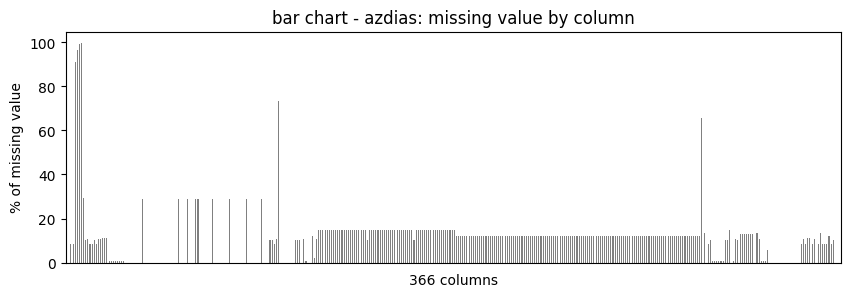

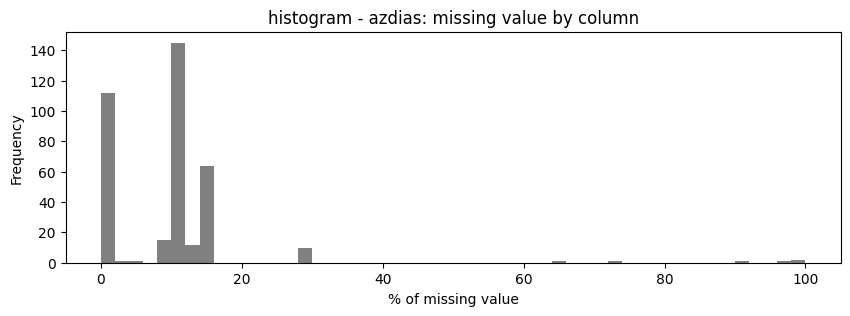

In [8]:
'''
missing value by columns of azdias
'''

miss_val_summary(azdias, 'column')

> xxx colum, 891K row데이터 인데, 심하게 missing value 많은 컬럼이 있음  
> info는 컬럼에 대한 정보, att는 데이터에 대한 정보를 가지고 있음

#### 1.2 customers

In [9]:
# 제출전 주석 해제
# '''
# load and file structure
# '''

# customers = pd.read_csv('../csv_pickle/Udacity_CUSTOMERS_052018.csv', sep=';')
# print (customers.info())
# customers.head()

In [10]:
customers = pd.read_pickle('../csv_pickle/customers.pickle')
customers.name = 'customers'
print (customers.info())
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
# '''
# missing value overview
# '''

# miss_val_overview(customers)

% of missing value in 369 columns of customers
mean    19.604925
std     15.143659
min      0.000000
25%      0.000000
50%     26.757352
75%     26.757352
max     99.876860


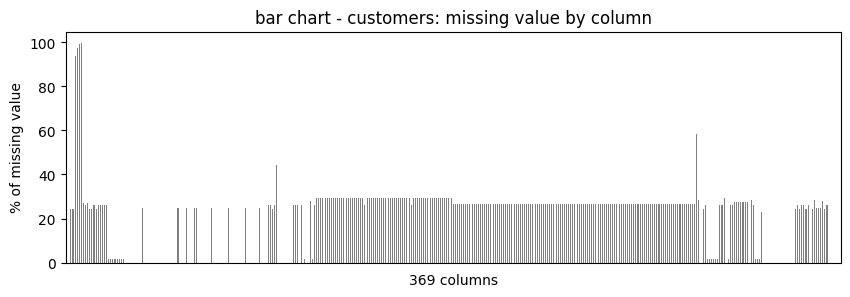

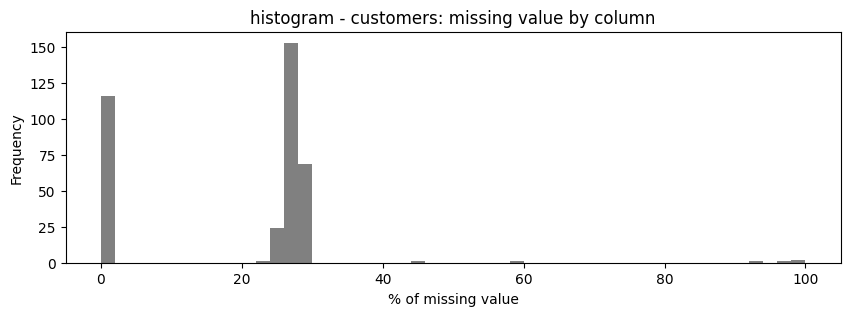

In [12]:
'''
missing value by column
'''

miss_val_summary(customers, 'column')

> xxx colum, 891K row데이터 인데, 심하게 missing value 많은 컬럼이 있음  
> 

#### 1.3 info

In [13]:
'''
load and overview
'''

info = pd.read_excel(
    'DIAS Information Levels - Attributes 2017.xlsx', header=1).iloc[:, 1:]
info.name = 'info'

print (info.info())
info.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  10 non-null     object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB
None


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


> info은 dataset의 Feature 즉 column names가 의미하는 바를 알려주는 파일임

#### 1.4 attr

In [14]:
'''
load and overview
'''

attr = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=1).iloc[:, 1:]
attr.name = 'attr'

print (attr.info())
attr[103:108]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Value,Meaning
103,NaN,NaN,9D,Mini-Jobber
104,NaN,NaN,9E,Socking Away
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,NaN,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,NaN,NaN,12,Wealthy Households-Young Couples With Children


In [15]:
# # not to run

# view_all(attr)

> attr은 dataset 각 column의 values가 의미하는 바를 알려주는 파일임

### 2. Understanding data contents

4개의 파일을 통해 살펴보면 2개 데이터 셋의 Feature 들은 simplified German acronym으로 되어 있어 readable 하지 못하며,    
2개의 information files를 통해 데이터셋 features 및 values 의 의미를 파악할 수 있음.   
따라서 데이터를 제대로 explore하고, 전처리하기 위해 data set이 어떤 feature들로 구성되는 지를 먼저 이해하고자 함

Therefore as the first step, I will understand the contents of data sets using 2 information files,     
and record points to be pre-processed. 

#### 2.1 dataset features

info와 attr은 dataset의 Feature 즉 column names가 의미하는 바를 알려주고 있음.   
따라서 info와 attr를 사용한 feature_desc를 정리하여 data set이 어떤 feature들로 구성되는 지를 먼저 이해하고자 함

As the data sets do not have information on what each feature (column name) exactly means,   
values of information files (info & attr) should be mapped to the features at first,   
to see how the data sets are structured.

In [16]:
'''
add information to column names of customers to know what features datasets have 
'''

# 먼저 모든 컬럼을 포함하고 있는 customers의 컬럼 이름을 값으로 갖는 Attribute 컬럼을 포함한 data frame을 만듦
feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc.name = 'feature_desc'

# info에서 Attribute의 상세내용을 mapping 시킴
feature_desc = vlookup(feature_desc, info, 'Attribute')

feature_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Attribute          369 non-null    object
 1   Information level  9 non-null      object
 2   Description        264 non-null    object
 3   Additional notes   17 non-null     object
dtypes: object(4)
memory usage: 14.4+ KB


feature_desc has 369 unique Attribute values as customers have 369 columns:   
264 common features in both of customers and info,    
and 105 features of customers not having Description values.

To enhance readability of data set - over 100 features are without description -   
I added 12 Description values from attr, and made a column of translation (ger_to_eng)   
for 93 features of which Descriptions are not found in both info and attr.   
However as this code-running takes somewhat long time, I saved the dataframe processed    
as df_feature.xlsx in root folder

In [17]:
# # For values of Attribute without Description, add 12 Description values from attr
# attr_to_add = attr[['Attribute', 'Description']].copy()
# attr_to_add.dropna(inplace = True)
# attr_to_add = attr_to_add.rename(columns = {'Description': 'Description_to_add'})

# feature_desc = vlookup(feature_desc, attr_to_add, 'Attribute')
# feature_desc.Description = np.where(
#     ((feature_desc.Description.isnull() == True) & (feature_desc.Description_to_add.isnull() == False)),
#     feature_desc.Description_to_add,
#     feature_desc.Description)
# feature_desc = feature_desc.drop('Description_to_add', axis=1)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# feature_desc['ger_to_eng'] = np.where(
#     feature_desc.Description.isnull(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.ger_to_eng.fillna('')

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
# feature_desc.name = 'feature_desc'
feature_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Attribute          369 non-null    object
 1   Information level  9 non-null      object
 2   Description        276 non-null    object
 3   Additional notes   17 non-null     object
 4   ger_to_eng         93 non-null     object
 5   Desc               369 non-null    object
dtypes: object(6)
memory usage: 20.2+ KB


In [18]:
'''
understand all features one by one using custom function view_all.

not to run this cell, to save space in final submission 
'''

# view_all(feature_desc)

feature_desc.head()

,Attribute,Information level,Description,Additional notes,ger_to_eng,Desc
0,LNR,NaN,NaN,NaN,LNR,LNR
1,AGER_TYP,NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,NaN,best-ager typology
2,AKT_DAT_KL,NaN,NaN,NaN,Act Dat KL,Act Dat KL
3,ALTER_HH,Household,main age within the household,NaN,NaN,main age within the household
4,ALTER_KIND1,NaN,NaN,NaN,Old child1,Old child1


I could not completely find exact meanings of all Attributes even with translations added,    
but could have overall understandings on features.    
As there are a few features containing similar contents, imputation steps for collinearity resolution   
and dimensionality reduction are needed before modelling.

In [19]:
'''
p_process dict to record point to be pre_processed
'''

p_process = {'2.1' : 'features of similar contents: collinearity resolution & dimensionality reduction'}

#### 2.2 feature alignment

Number of features by file and feature intersection & difference between files are as below

In [20]:
feature_dict = {
    'azdias' : set(azdias.columns.unique()),
    'customers' : set(customers.columns.unique()),
    'info' : set(info.Attribute.dropna().unique()),
    'attr' : set(attr.Attribute.dropna().unique()),
    'feature_desc' : set(feature_desc.Attribute.dropna().unique())
    }

In [21]:
print ('Number of features by file')
for k, v in feature_dict.items():
    print (k, ':', len(v))

Number of features by file
azdias : 366
customers : 369
info : 313
attr : 314
feature_desc : 369


In [22]:
print ('Feature intersection & difference between files')
for i in range(0, 5):
    for j in range (0, 5):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[key_1 + '_intsec_' + key_2] = intsec
        feature_dict['in_' + key_1 + '_notin_' + key_2] = ft_diff
        
        intsec_print = key_1 + ' & ' + key_2 + ' intersection:'
        ft_diff_print = ' /  in ' + key_1 + ' & not-in ' + key_2 + ':'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

'''
customer에 있는데 feature_desc에 없는 것들 관련
info, attr에 유사한 이름으로 있을 수 있음
나중에 attr에 없는 값을 유추할 때 생각해 볼 사항

attr이 커버하지 못하는 feature를 살펴보고, 어떻게 전처리 할 지 정리함   
--> 컬럼명과 내용의 유사도를 파악하여 동일 전처리 룰 적용 / 또는 info에는 있는데 typo일 수도

Unique Point가 될 수 있음
'''

Feature intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & info intersection:            264  /  in azdias & not-in info:          102
azdias & attr intersection:            272  /  in azdias & not-in attr:           94
azdias & feature_desc intersection:    366  /  in azdias & not-in feature_desc:    0
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & info intersection:         264  /  in customers & not-in info:       105
customers & attr intersection:         272  /  in customers & not-in attr:        97
customers & feature_desc intersection: 369  /  in customers & not-in feature_desc: 0
info & azdias intersection:            264  /  in info & not-in azdias:           49
info & customers intersection:         264  /  in info & not-in customers:        49
info & attr intersection:              300  /  in info & not-in attr:             13
info & feature_de

'\ncustomer에 있는데 feature_desc에 없는 것들 관련\ninfo, attr에 유사한 이름으로 있을 수 있음\n나중에 attr에 없는 값을 유추할 때 생각해 볼 사항\n\nattr이 커버하지 못하는 feature를 살펴보고, 어떻게 전처리 할 지 정리함   \n--> 컬럼명과 내용의 유사도를 파악하여 동일 전처리 룰 적용 / 또는 info에는 있는데 typo일 수도\n\nUnique Point가 될 수 있음\n'

#### 2.3 data set values

attr은 각 column의 values가 의미하는 바를 알려주고 있음.  
따라서 attr을 활용하여 각 feature가 어떤 데이터를 가지고 있는지 파악하고
어떤 값들에 대한 전처리가 필요한지를 먼저 정리함

2.2에서 살펴본 바와 같이 272개 피쳐는 attr을 통해 설명이 가능하므로

The values of the data sets can also be readable by mapping values of Value and Meaning of attr.   
In this section, 데이터 종류 (연속/이산), 이상치, 사실상의 null value 등 데이터 전처리를 위한 데이터의 내용적 측면을 점검하겠음.

##### 2.3.1 attr modification

attr 내용은 neat하게 정리되어 있지 않은 상태로, 일부 Description 밑에    
추가 설명으로 보이는 문구 셀이 있고, 각 블록의 첫 행에만 Attribute 및 Description     
값이 있어 at first proper data format으로 변형함

In [23]:
'''
merge additional information cells to Description cells
'''
attr_org = attr.copy() # 먼저 기존 attr을 다른 이름으로 놓아 두고

attr['description_shift'] = attr.Description.shift(-1).fillna('')
# Description 밑에 있던 설명문구를 description_shift를 사용하여 병합
attr.Description = attr.Description.mask(
    ~(attr.Attribute.isna()),
    attr.Description + ' ' + attr.description_shift)
# 기존 Description 밑의 설명 문구 삭제
attr.Description = attr.Description.mask(
    (attr.Attribute.isna()) & ~(attr.Description.isna()),
    np.nan) # 기존
attr = attr.drop(columns = 'description_shift')

'''
fill null cells as only 1st lines of information have values
'''
attr[['Attribute', 'Description']] = attr[
    ['Attribute', 'Description']].fillna(method = 'ffill')

print (attr.info())
attr.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    2258 non-null   object
 1   Description  2258 non-null   object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


##### 2.3.2 data values by type

After extracting 272 features in both of customers and attr, I will analyze data values by type   

In [24]:
'''
extract 272 features
'''
in_attr = feature_dict['feature_desc_intsec_attr']
in_attr = attr[attr.Attribute.isin(in_attr)].copy()

print (in_attr.Attribute.nunique())
in_attr.info()

272
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1916 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    1916 non-null   object
 1   Description  1916 non-null   object
 2   Value        1916 non-null   object
 3   Meaning      1905 non-null   object
dtypes: object(4)
memory usage: 74.8+ KB


From 272 feature extracted, 2 features have NaN in their Meaning.    
I decided to drop them, as they have other features with similar and more detailed Meaning.

In [25]:
in_attr[in_attr.Meaning.isnull()]

,Attribute,Description,Value,Meaning
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN
1913,LP_FAMILIE_GROB,familytyp rough,11,NaN
1977,LP_STATUS_GROB,social status rough,2,NaN
1979,LP_STATUS_GROB,social status rough,4,NaN
1980,LP_STATUS_GROB,social status rough,5,NaN
1982,LP_STATUS_GROB,social status rough,7,NaN


In [26]:
in_attr[in_attr.Attribute.str.contains('LP_FAMILIE')]

,Attribute,Description,Value,Meaning
1892,LP_FAMILIE_FEIN,familytyp fine,1,single
1893,LP_FAMILIE_FEIN,familytyp fine,2,couple
1894,LP_FAMILIE_FEIN,familytyp fine,3,young single parent
1895,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager
1896,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age
1897,LP_FAMILIE_FEIN,familytyp fine,6,young family
1898,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager
1899,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household


In [27]:
# in_attr[in_attr.Attribute.str.contains('LP_STATUS')]

In [28]:
p_process['3.2.1'] = 'drop features LP_FAMILIE_GROB / LP_STATUS_GROB'

in_attr = in_attr[(in_attr.Attribute != 'LP_FAMILIE_GROB')
                        & (in_attr.Attribute != 'LP_STATUS_GROB')]

Column Value_type is added to divide remaining 270 features by data type

In [29]:
in_attr['Value_type'] = in_attr.Value.map(type)
in_attr.Value_type.value_counts()

<class 'int'>    1753
<class 'str'>     142
Name: Value_type, dtype: int64

##### 2.3.3 int values

262 features in int type are categorized by their min/max values.

In [30]:
'''
in_attr_num containing int type Value
'''
in_attr_num = in_attr[in_attr.Value_type == int]
print ('number of features in int type:', in_attr_num.Attribute.nunique())

'''
pv_attr: summary of in_attr_num with min/max values categorized
'''
pv_attr = pd.pivot_table(
    in_attr_num,
    index = ['Attribute', 'Description'],
    values = 'Value',
    aggfunc = [min, max]
    )
pv_attr['min_max_cat'] = pv_attr['min'].astype(str) + ' to ' + pv_attr['max'].astype(str)
pv_attr = pv_attr.sort_values(by = 'min_max_cat')

pv_attr.min_max_cat.value_counts()

number of features in int type: 262


-1 to 5     109
1 to 5       32
1 to 7       16
1 to 10      13
0 to 5       12
0 to 6       11
-1 to 3       9
0 to 4        7
0 to 3        7
1 to 3        6
-1 to 4       5
1 to 6        4
1 to 4        4
1 to 9        4
-1 to 2       3
0 to 10       3
1 to 12       2
0 to 1        2
-1 to 8       2
-1 to 6       2
0 to 21       1
1 to 11       1
1 to 15       1
1 to 2        1
-1 to 9       1
1 to 40       1
-1 to 7       1
1 to 8        1
-1 to -1      1
Name: min_max_cat, dtype: int64

From min/max categories above, all 262 features seem to contain discrete values.   
To be further checked are:   
* if Value -1 and 0 contain data equal to null or -inf   
* if max Values contain data equal to null or inf

* In case of Value -1 and 0:   
  - Values with Meaning of list to_null should be replaced to NaN.   
  - For numeric features exclusively in datasets (not in attr),   
  Value -1 should be replaced to NaN as they mean 100% NaN in attr reference,   
  and Value 0 should be kept as 'none' in Meaning is not for replacement. 

In [31]:
attr_num_mn1 = in_attr_num[in_attr_num.Value == -1]
attr_num_mn1.Meaning.value_counts()

unknown    133
Name: Meaning, dtype: int64

In [32]:
attr_num_0 = in_attr_num[in_attr_num.Value == 0]
attr_num_0.Meaning.value_counts()

none                                                136
no transactions known                                10
no Online-transactions within the last 12 months      3
unknown                                               2
no classification possible                            1
unknown / no main age detectable                      1
doesn't belong to the green avantgarde                1
classification not possible                           1
no 1-2 family homes                                   1
no 3-5 family homes                                   1
no 6-10 family homes                                  1
no >10 family homes                                   1
external supplied hedonists                           1
no score calculated                                   1
Name: Meaning, dtype: int64

In [33]:
'''
select Meaning values to be NaN
'''
to_null = ['unknown','no transactions known', 'no classification possible',
           'unknown / no main age detectable', 'classification not possible',
           'no score calculated'
            ]
'''
select Meaning values to be checked for NaN
'''
maybe_null = ['none']

p_process['3.2.1-to_null'] = 'replace Values with Meaning in to_null to NaN'
p_process['3.2.1-value_0_-1'] = 'for features not in attr, replace Value -1 to NaN'

In [34]:
'''
check if maybe_null value can be added to to_nul
'''
null_check = in_attr_num[in_attr_num['Meaning'].isin(maybe_null)]['Attribute'].tolist()
null_check = in_attr_num[in_attr_num['Attribute'].isin(null_check)]
null_check = vlookup(null_check, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
pv_attr = pd.pivot_table(
    null_check,
    index = ['Attribute', 'Description', 'Desc', 'Additional notes'],
    values = ['Meaning', 'Value'],
    aggfunc = lambda x: list(x))
pv_attr.head()

,,,,Meaning,Value
Attribute,Description,Desc,Additional notes,,
KBA05_ALTER1,share of car owners less than 31 years old,share of car owners less than 31 years old,no_info,"[none, low, average, high, very high]","[0, 1, 2, 3, 4]"
KBA05_ALTER4,share of cars owners elder than 61 years,share of cars owners elder than 61 years,no_info,"[none, very low, low, average, high, very high]","[0, 1, 2, 3, 4, 5]"
KBA05_ANHANG,share of trailers in the microcell,share of trailers in the microcell,no_info,"[none, some, some more, very many]","[0, 1, 2, 3]"
KBA05_CCM4,share of cars with more than 2499ccm,share of cars with more than 2499ccm,no_info,"[none, low, average, high, very high]","[0, 1, 2, 3, 4]"
KBA05_DIESEL,share of cars with Diesel-engine in the microcell,share of cars with Diesel-engine in the microcell,no_info,"[none, very low, low, average, high]","[0, 1, 2, 3, 4]"


* In case of max Values, most Values with Meanings equal to NaN are already in list to_null,   
  except Meaning 'inactive' added to list to_null.


In [35]:
# # pv_attr_num에서 max Value가 7보다 큰 Attribute를 추출함
# max_over_7 = pv_attr_num[pv_attr_num[('max', 'Value')] > 7].index.get_level_values(0)

# # max가 7보다 큰 Attribut의 Meaning을 List에 담아 데이터가 discrete / continuous 여부를 파악
# max_over_7 = in_attr_num[in_attr_num.Attribute.isin(max_over_7)]
# pv_max_over_7 = pd.pivot_table(
#     max_over_7,
#     index = 'Attribute',
#     values = 'Meaning',
#     aggfunc = lambda x: x)

# view_all(pv_max_over_7)

In [36]:
'''
extract Meaning of max values using corresponding index
'''
in_attr_num['Value'] = in_attr_num['Value'].astype(float)
max_idxmax = in_attr_num.groupby('Attribute')['Value'].idxmax()

in_attr_num.loc[max_idxmax, 'Meaning'].unique()

/var/folders/y5/wyn61d3n7wxdpg5j1f0rpvc80000gn/T/ipykernel_3869/3290773488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_attr_num['Value'] = in_attr_num['Value'].astype(float)


array(['experience-driven elderly', 'uniformly distributed',
       '01.01.1995 bis 31.12.1999', 'female', 'more than 100 km ',
       'urban working class',
       'Advertising-Enthusiast with restricted Cross-Channel-Behaviour ',
       'very high activity', 'no transactions known',
       '100% Online-transactions within the last 12 months', 'Inactive',
       'more than 999 HH/²', 'unremarkable', 'very low',
       'mixed building without actually known company ',
       'residential cell', 'without vacation',
       'belongs to the green avantgarde', 'jaunty hedonists ',
       'very low income', 'distance to the city centre > 40 km',
       'very high', 'very many', 'very high share of 1-2 family homes',
       'very high share of 3-5 family homes',
       'high share of 6-10 family homes',
       'high share of >10 family homes', 'very high car quote',
       'mainly business buildings in the microcell', 'high',
       '>=23 buildings', 'new building', 'way above average',
     

In [37]:
'''
select Meaning values to be checked for NaN
'''
maybe_null = ['uniformly distributed', 'no transactions known', 'Inactive', 'unremarkable',
              'unknown', 'other', 'indifferent']

maybe_null = [i for i in maybe_null if i not in to_null]

In [38]:
'''
extract Attributes of which max values are Meanings of list maybe_null
'''
max_check = in_attr_num.loc[max_idxmax]
max_check = max_check[max_check['Meaning'].isin(maybe_null)]['Attribute'].tolist()
'''
check what maybe_null values to add to to_nul
'''
max_check = in_attr_num[in_attr_num['Attribute'].isin(max_check)]
max_check = vlookup(max_check, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
pv_attr = pd.pivot_table(
    max_check,
    index = ['Attribute', 'Description', 'Desc', 'Additional notes'],
    values = ['Meaning', 'Value'],
    aggfunc = lambda x: list(x))
view_all(pv_attr)

,,,,Meaning,Value
Attribute,Description,Desc,Additional notes,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,age through prename analysis,modelled on millions of first name-age-reference data,"[< 30 years, 30 - 45 years, 46 - 60 years, > 60 years, uniformly distributed]","[1.0, 2.0, 3.0, 4.0, 9.0]"
D19_KONSUMTYP,consumption type,consumption type,no_info,"[Universal, Versatile, Gourmet, Family, Informed , Modern, Inactive]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]"
FINANZTYP,best descirbing financial type for the person,best descirbing financial type for the peron,no_info,"[unknown, low finacial interest, money saver, main focus is the own house, be prepared, Investor, unremarkable]","[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"
TITEL_KZ,flag whether this person holds an academic title,flag whether this person holds an academic title,no_info,"[Dr., Dr. Dr., Prof., Prof. Dr., other]","[1.0, 2.0, 3.0, 4.0, 5.0]"
ZABEOTYP,typification of energy consumers,typification of energy consumers,modelled on different AZ DIAS data,"[green, smart, fair supplied, price driven, seeking orientation, indifferent]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"


In [39]:
to_null.append('Inactive')

##### 2.3.4 str values

98 features in str type are analyzed

In [40]:
in_attr_str = in_attr[in_attr.Value_type == str]
print ('number of features in str type:', in_attr_str.Attribute.nunique())
print ('number of intersection features in int & str type:',
       len(set(in_attr_str.Attribute.unique()).intersection(set(in_attr_num.Attribute.unique()))), '\n')

pv_attr = pd.pivot_table(
    in_attr_str,
    index = ['Attribute', 'Description', 'Meaning'],
    values = 'Value',
    aggfunc = lambda x: list(x))

pv_attr.head(10)

number of features in str type: 98
number of intersection features in int & str type: 90 



Value
Attribute            Description                                        Meaning                                           
ALTERSKATEGORIE_GROB age classification through prename analysis        unknown                                    [-1, 0]
ANREDE_KZ            gender                                             unknown                                    [-1, 0]
ANZ_HAUSHALTE_AKTIV  number of households in the building number of ... numeric value (typically coded from 1-10)      […]
ANZ_HH_TITEL         number of academic title holder in building num... numeric value (typically coded from 1-10)      […]
ANZ_PERSONEN         number of adult persons in the household number... numeric value (typically coded from 1-3)       […]
ANZ_TITEL            number of professional title holder in househol... numeric value (typically coded from 1-10)      […]
CAMEO_DEU_2015       CAMEO classification 2015 - detailled classific... Active Retirement                             [5F]
                                                                        Afternoon Talk Show                           [9C]
                                                                        Career & Family                               [3A]
                                                                        City Nobility                                 [1E]

As the case of 2 numbers paired to mean 'unknown' is detected, pivot table is remade disregarding this case.

In [41]:
in_attr_str = in_attr_str[in_attr_str.Meaning != 'unknown']

pv_attr_str = pd.pivot_table(
    in_attr_str,
    index = ['Attribute', 'Description'],
    values = 'Value',
    aggfunc = lambda x: x)

view_all(pv_attr_str)

,,Value
Attribute,Description,
ANZ_HAUSHALTE_AKTIV,number of households in the building number of academic title holder in building,…
ANZ_HH_TITEL,number of academic title holder in building number of adult persons in the household,…
ANZ_PERSONEN,number of adult persons in the household number of professional title holder in household,…
ANZ_TITEL,number of professional title holder in household distance to next urban centre,…
CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3C, 3D, 4A, 4B, 4C, 4D, 4E, 5A, 5B, 5C, 5D, 5E, 5F, 6A, 6B, 6C, 6D, 6E, 6F, 7A, 7B, 7C, 7D, 7E, 8A, 8B, 8C, 8D, 9A, 9B, 9C, 9D, 9E]"
GEBURTSJAHR,year of birth vacation habits,…
KBA13_ANZAHL_PKW,number of cars in the PLZ8 share of AUDI within the PLZ8,…
MIN_GEBAEUDEJAHR,year the building was first mentioned in our database moving patterns,…
OST_WEST_KZ,flag indicating the former GDR/FRG,"[O, W]"


CAMEO_DEU_2015 and OST_WEST_KZ contain discrete data.    
There are 7 continuous data detected, of which skewness should be checked for scaling.

In [42]:
cont_feature = in_attr_str[in_attr_str['Meaning'].str.contains('numeric value')]

In [43]:
cont_feature = in_attr_str[in_attr_str['Meaning'].str.contains('numeric value')]
cont_ft = list(cont_feature['Attribute'].unique())
p_process['3.2.2'] = 'check skewness for scaling of ' + ', '.join(cont_ft)

### 3. Dataset exploration

Based on understandings on data contents from information files in section2 above,   
I will explore 2 main datasets to finalize preparation for pre-processing.   

In [44]:
'''
create a concatenated dataframe of 2datasets for temporary use
'''
concat_data = pd.concat([customers, azdias], axis=0)
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082873 entries, 0 to 891220
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(93), object(8)
memory usage: 3.0+ GB


##### 3.3.1 numeric values

extract 92 features in numeric type

In [45]:
concat_num = concat_data.select_dtypes(include = ['int', 'float'])
cc_num = concat_num.copy()
concat_num.shape

(1082873, 361)

form the summary statistics dataframe of numeric features

In [46]:
# extract summary statistics of the numeric features by applying describe and transpose
concat_num = concat_num.describe().T.reset_index()

# merge Desc (information on Attribute) from feature_desc and add min_max_cat
concat_num = concat_num.rename(columns = {'index':'Attribute'})
concat_num = vlookup(concat_num, feature_desc, 'Attribute', 'Desc')
concat_num['min_max_cat'] = concat_num['min'].astype(str) + ' to ' + concat_num['max'].astype(str)
concat_num.head()

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,min_max_cat
0,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,1.0 to 1082873.0
1,AGER_TYP,1082873.0,-0.234051,1.263860,-1.0,-1.0,-1.0,1.0,3.0,best-ager typology,-1.0 to 3.0
2,AKT_DAT_KL,962778.0,4.018992,3.569841,1.0,1.0,1.0,9.0,9.0,Act Dat KL,1.0 to 9.0
3,ALTER_HH,962778.0,10.937633,7.452130,0.0,0.0,13.0,17.0,21.0,main age within the household,0.0 to 21.0
4,ALTER_KIND1,92824.0,11.820413,4.090882,2.0,8.0,12.0,15.0,18.0,Old child1,2.0 to 18.0


analyze numeric features by categorizing on min/max values

In [47]:
concat_num.min_max_cat.unique()

array(['1.0 to 1082873.0', '-1.0 to 3.0', '1.0 to 9.0', '0.0 to 21.0',
       '2.0 to 18.0', '4.0 to 18.0', '7.0 to 18.0', '0.0 to 25.0',
       '0.0 to 595.0', '0.0 to 23.0', '0.0 to 11.0', '0.0 to 45.0',
       '0.0 to 449.0', '0.0 to 6.0', '1.0 to 7.0', '1.0 to 6.0',
       '1.0 to 5.0', '1.0 to 10.0', '0.0 to 7.0', '0.0 to 10.0',
       '0.0 to 5.0', '0.0 to 1.0', '1900.0 to 2018.0', '1.0 to 56.0',
       '1.0 to 8.0', '0.0 to 2017.0', '11.0 to 50.0', '1.0 to 12.0',
       '0.0 to 9.0', '0.0 to 4.0', '0.0 to 3.0', '0.0 to 2.0',
       '0.0 to 2300.0', '1.0 to 3.0', '1.0 to 4.0', '0.0 to 40.0',
       '0.0 to 12.0', '1985.0 to 2016.0', '0.0 to 15.0', '-1.0 to 2.0',
       '1.0 to 11.0', '1.0 to 13.0', '0.0 to 8.0', '1.0 to 2.0'],
      dtype=object)

All features seem to contain categorical values except LNR which seems to mean line order and should be dropped.    
From features in attr, nearly all cases of value 0 imply Meaning to be dropped.

In [48]:
concat_cont_feature = concat_num[concat_num['max'] > 100][['Attribute', 'Desc']]
concat_cont_ft = list(concat_cont_feature.Attribute.unique())

view_all(concat_num[concat_num['Attribute'].isin(concat_cont_ft)])

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,min_max_cat
0,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,1.0 to 1082873.0
9,ANZ_HAUSHALTE_AKTIV,939798.0,7.786384,15.482165,0.0,1.0,3.0,9.0,595.0,number of households known in this building,0.0 to 595.0
13,ANZ_STATISTISCHE_HAUSHALTE,939798.0,7.162317,14.347487,0.0,1.0,3.0,8.0,449.0,Anz statistical households,0.0 to 449.0
93,EINGEZOGENAM_HH_JAHR,962778.0,2003.044442,7.120764,1900.0,1997.0,2002.0,2009.0,2018.0,Intended HH year,1900.0 to 2018.0
106,GEBURTSJAHR,1082873.0,1083.871938,976.933275,0.0,0.0,1939.0,1967.0,2017.0,year of birth,0.0 to 2017.0
187,KBA13_ANZAHL_PKW,925792.0,626.908028,340.528955,0.0,390.0,556.0,786.0,2300.0,number of cars in the PLZ8,0.0 to 2300.0
306,MIN_GEBAEUDEJAHR,939798.0,1993.243781,3.296842,1985.0,1992.0,1992.0,1993.0,2016.0,year the building was first mentioned in our database,1985.0 to 2016.0


In [80]:
(cc_num['ANZ_HAUSHALTE_AKTIV'] == 0).sum()

8913

* LNR을 먼저 정리하고
* 0 값이 말이 안되는 경우 제외하고
* 마지막으로 아웃라이어를 살펴봄

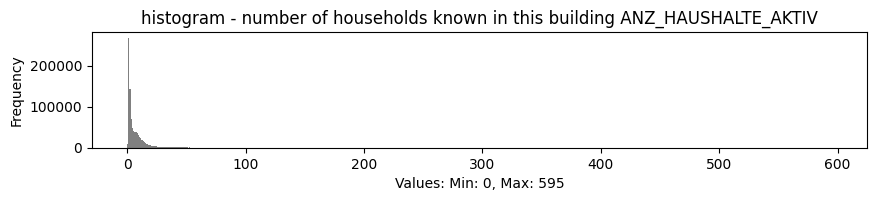

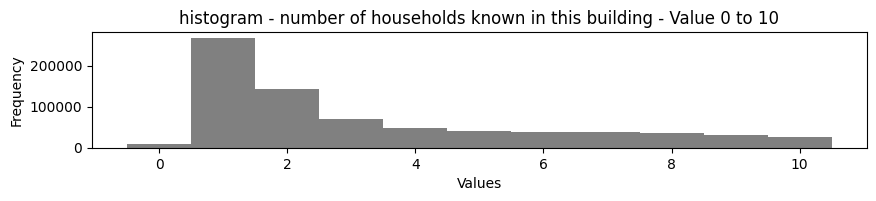

595 0.1% 536 0.0% 523 0.1% 515 0.0% 445 0.1% 438 0.1% 430 0.1% 414 0.0% 404 0.0% 395 0.0% 379 0.1% 378 0.0% 377 0.1% 367 0.1% 366 0.0% 353 0.1% 348 0.1% 347 0.1% 346 0.1% 344 0.2% 333 0.1% 331 0.1% 328 0.1% 326 0.0% 321 0.2% 318 0.1% 317 0.1% 316 0.1% 314 0.1% 311 0.2% 307 0.1% 305 0.3% 304 0.1% 301 0.1% 293 0.0% 290 0.1% 286 0.1% 285 0.0% 283 0.1% 280 0.1% 277 0.1% 276 0.1% 274 0.1% 272 0.0% 267 0.1% 266 0.0% 265 0.2% 263 0.1% 260 0.0% 259 0.1% 258 0.2% 256 0.0% 255 0.0% 254 0.0% 253 0.3% 252 0.1% 250 0.0% 249 0.0% 247 0.1% 246 0.2% 244 0.0% 243 0.1% 242 0.1% 241 0.1% 240 0.1% 238 0.0% 237 0.0% 236 0.1% 232 0.0% 231 0.1% 230 0.2% 229 0.1% 228 0.1% 226 0.0% 225 0.2% 224 0.0% 223 0.2% 222 0.2% 221 0.1% 220 0.0% 219 0.1% 218 0.1% 216 0.1% 215 0.1% 214 0.1% 213 0.0% 211 0.1% 210 0.3% 209 0.2% 208 0.1% 207 0.1% 206 0.1% 205 0.1% 204 0.1% 202 0.1% 201 0.1% 200 0.1% 199 0.2% 198 0.2% 197 0.1% 196 0.1% 195 0.4% 194 0.1% 193 0.1% 191 0.1% 190 0.1% 189 0.1% 187 0.1% 186 0.2% 185 0.1% 184 0.1% 1

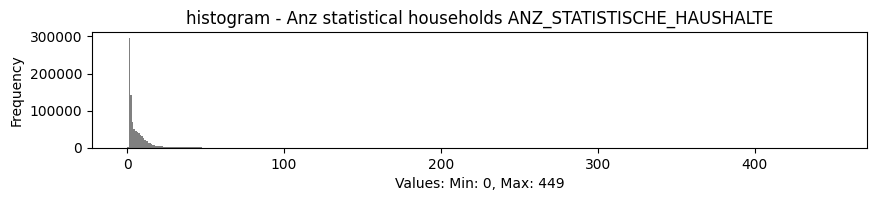

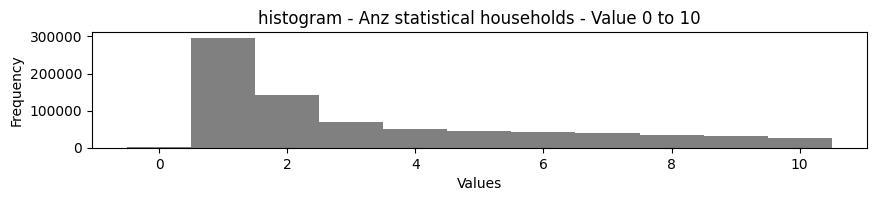

449 0.0% 445 0.1% 375 0.1% 371 0.0% 369 0.1% 367 0.1% 366 0.1% 365 0.1% 354 0.2% 353 0.1% 342 0.1% 339 0.3% 336 0.0% 328 0.1% 322 0.2% 319 0.1% 317 0.2% 314 0.0% 309 0.1% 304 0.1% 303 0.1% 299 0.1% 297 0.2% 296 0.1% 292 0.2% 289 0.0% 286 0.1% 284 0.1% 274 0.1% 269 0.1% 268 0.1% 264 0.1% 262 0.0% 258 0.1% 257 0.1% 256 0.1% 253 0.1% 252 0.1% 251 0.3% 248 0.1% 245 0.0% 244 0.1% 243 0.1% 242 0.1% 241 0.0% 240 0.1% 239 0.1% 238 0.1% 237 0.1% 235 0.1% 234 0.1% 233 0.1% 230 0.4% 229 0.0% 228 0.1% 227 0.0% 225 0.2% 223 0.2% 222 0.2% 218 0.1% 217 0.1% 216 0.0% 214 0.1% 213 0.1% 212 0.2% 209 0.1% 205 0.1% 204 0.1% 203 0.0% 202 0.2% 201 0.0% 200 0.1% 199 0.1% 198 0.0% 197 0.0% 195 0.1% 194 0.1% 193 0.1% 192 0.2% 190 0.0% 189 0.0% 187 0.1% 186 0.1% 185 0.1% 184 0.1% 183 0.2% 182 0.0% 181 0.2% 180 0.3% 179 0.1% 178 0.1% 177 0.1% 176 0.1% 175 0.0% 174 0.3% 173 0.1% 172 0.3% 171 0.1% 170 0.2% 169 0.1% 168 0.2% 167 0.1% 166 0.1% 165 0.0% 164 0.2% 163 0.4% 162 0.1% 161 0.2% 160 0.1% 159 0.2% 158 0.2% 1

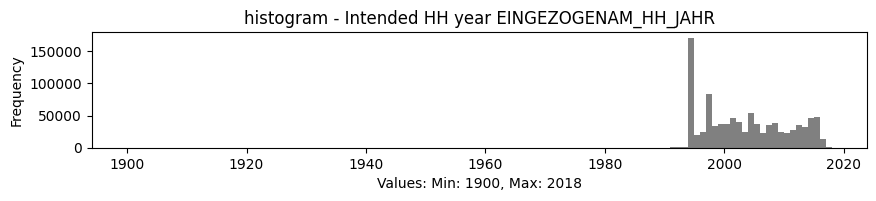

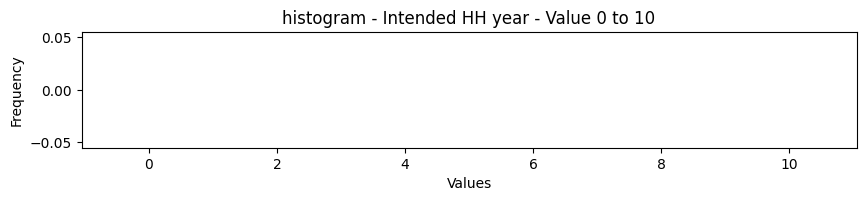

1904 0.0% 1900 0.0% 


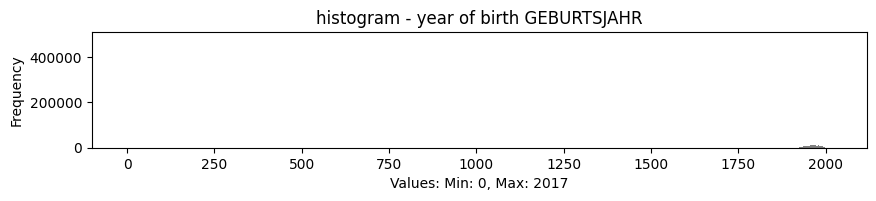

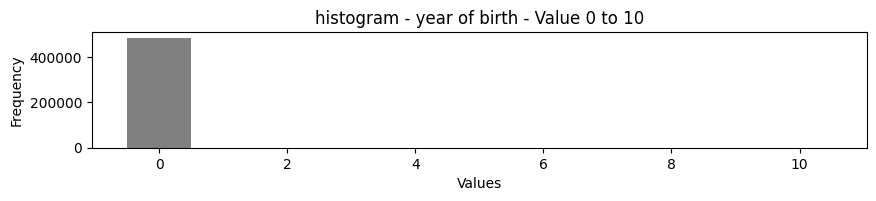

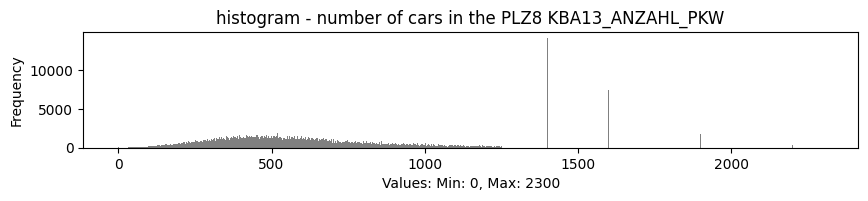

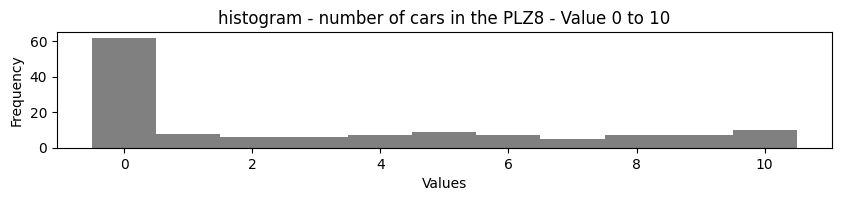

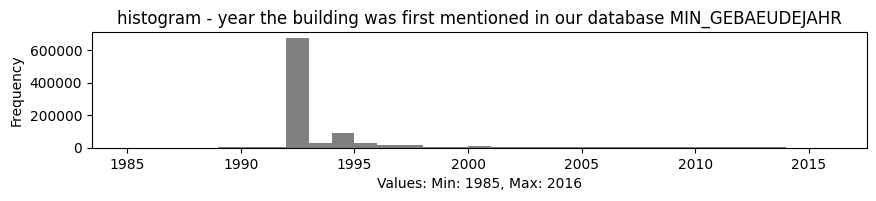

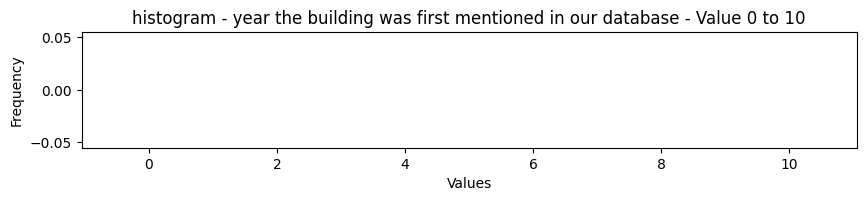

2016 1.4% 2015 8.6% 2014 12.2% 2013 15.1% 2012 22.1% 2011 22.9% 2010 17.3% 2009 24.6% 2008 27.1% 2007 26.8% 2006 24.3% 2005 67.0% 2004 36.1% 2003 41.3% 2002 52.3% 2001 72.9% 2000 91.8% 1999 53.9% 1986 1.7% 1985 1.4% 


In [86]:
for i in concat_cont_ft[1:]:

    min_val = cc_num[i].min()
    max_val = cc_num[i].max()
    bin_interval = 1
    bin_edges = np.arange(min_val, max_val + bin_interval, bin_interval)

    desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
    count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

    ax = cc_num[i].plot(
        kind = 'hist',
        figsize=(10, 1.5),
        color='gray',
        bins = bin_edges,
        align = 'mid',
        title = ('histogram - ' + desc_val + ' ' + i)
        );
    ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
    plt.show()
    
    ax = cc_num[i].plot(
        kind = 'hist',
        figsize=(10, 1.5),
        color='gray',
        bins = np.arange(-0.5, 11.5, 1),
        align = 'mid',
        title = ('histogram - ' + desc_val + ' - Value 0 to 10')
        );
    ax.set_xlabel('Values');
    plt.show()
    
    # Define the outlier thresholds by applying multiplier 5.0
    q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
    q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
    iqr = q3 - q1
    lower_threshold = q1 - 5.0 * iqr
    upper_threshold = q3 + 5.0 * iqr

    # Identify outliers
    col_val = cc_num[i].values
    outliers = sorted(set([i for i in col_val if i < lower_threshold or i > upper_threshold]), reverse = True)
    for j in outliers:
        print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
    print ('\n', '==========' * 10)

In [50]:
concat_cont_ft = list(concat_cont_feature.Attribute.unique())
set(concat_cont_ft) - set(cont_ft)
# cont_ft: list of continuous features in 2.3.4

{'ANZ_STATISTISCHE_HAUSHALTE', 'EINGEZOGENAM_HH_JAHR', 'LNR'}

In [51]:
p_process['3.3.1-LNR'] = 'drop LNR'
cont_ft = list(set(cont_ft).union(set(concat_cont_ft)))
p_process['3.3.1'] = 'check skewness for scaling of ' + ', '.join(cont_ft)

##### 3.3.2 str values

extract 5 features in str type

In [52]:
concat_str = concat_data.select_dtypes(exclude = ['int', 'float'])
print(concat_str.shape)
concat_str

(1082873, 8)


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1.0,13.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4.0,24.0,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7.0,41.0,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
...,...,...,...,...,...,...,...,...
891216,7A,7.0,41.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W,NaN,NaN
891217,9D,9.0,51.0,D19_UNBEKANNT,1992-02-10 00:00:00,W,NaN,NaN
891218,4C,4.0,24.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W,NaN,NaN
891219,9D,9.0,51.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,NaN,NaN


type EINGEFUEGT_AM should be changed to datetime 

In [53]:
concat_str = concat_str.drop('EINGEFUEGT_AM', axis = 1)
p_process['3.3.2'] = 'change type of EINGEFUEGT_AM to datetime'

In [54]:
# extract values of Attribute in list
concat_str = pd.DataFrame(
    {'Attribute': concat_str.columns,
     'value_list': concat_str.values.T.tolist()})
concat_str['value_list'] = concat_str['value_list'].apply(
    lambda x: list(pd.Series(x).drop_duplicates().dropna()))

# merge Desc (information on Attribute) from feature_desc and add min_max_cat
concat_str = vlookup(concat_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])

view_all(concat_str)

,Attribute,value_list,Desc,Additional notes
0,CAMEO_DEU_2015,"[1A, 5D, 4C, 7B, 3B, 1D, 9E, 2D, 4A, 6B, 9D, 8B, 5C, 9C, 4E, 6C, 8C, 8A, 5B, 9B, 3D, 2A, 3C, 5F, 7A, 1E, 2C, 7C, 5A, 2B, 6D, 7E, 5E, 6E, 3A, 9A, 4B, 1C, 1B, 6A, 8D, 7D, 6F, 4D, XX]",CAMEO_4.0: specific group,NaN
1,CAMEO_DEUG_2015,"[1.0, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, 6, 3, 8, 9, 2, 4, 1, 7, 5, X]",CAMEO_4.0: uppergroup,New German CAMEO Typology established together with Call Credit in late 2015
2,CAMEO_INTL_2015,"[13.0, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0, 51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0, 45, 25, 55, 51, 14, 54, 43, 22, 15, 24, 35, 23, 12, 44, 41, 52, 31, 13, 34, 32, 33, XX]",CAMEO INTL 2015,NaN
3,D19_LETZTER_KAUF_BRANCHE,"[D19_UNBEKANNT, D19_BANKEN_GROSS, D19_NAHRUNGSERGAENZUNG, D19_SCHUHE, D19_BUCH_CD, D19_DROGERIEARTIKEL, D19_SONSTIGE, D19_TECHNIK, D19_VERSICHERUNGEN, D19_TELKO_MOBILE, D19_VOLLSORTIMENT, D19_HAUS_DEKO, D19_ENERGIE, D19_REISEN, D19_BANKEN_LOKAL, D19_VERSAND_REST, D19_BEKLEIDUNG_REST, D19_FREIZEIT, D19_BEKLEIDUNG_GEH, D19_TELKO_REST, D19_SAMMELARTIKEL, D19_BANKEN_DIREKT, D19_KINDERARTIKEL, D19_BANKEN_REST, D19_LEBENSMITTEL, D19_GARTEN, D19_HANDWERK, D19_RATGEBER, D19_DIGIT_SERV, D19_BIO_OEKO, D19_BILDUNG, D19_WEIN_FEINKOST, D19_TIERARTIKEL, D19_LOTTO, D19_KOSMETIK]",D19 Last purchase industry,NaN
4,OST_WEST_KZ,"[W, O]",flag indicating the former GDR/FRG,NaN
5,PRODUCT_GROUP,"[COSMETIC_AND_FOOD, FOOD, COSMETIC]",Product Group,NaN
6,CUSTOMER_GROUP,"[MULTI_BUYER, SINGLE_BUYER]",Customer Group,NaN


In [55]:
p_process['3.3.2-XX'] = 'replace Value X, XX to NaN'

### 4. Pre-processing

In [56]:
p_process_items = pd.DataFrame(p_process, index = [0]).T.rename(columns = {0 : 'pre-processing items'})
p_process_items = p_process_items.drop(index = '3.2.2', axis = 0)
view_all(p_process_items)

,pre-processing items
2.1,features of similar contents: collinearity resolution & dimensionality reduction
3.2.1,drop features LP_FAMILIE_GROB / LP_STATUS_GROB
3.2.1-to_null,replace Values with Meaning in to_null to NaN
3.2.1-value_0_-1,"for features not in attr, replace Value -1 to NaN"
3.3.1-LNR,drop LNR
3.3.1,"check skewness for scaling of LNR, ANZ_TITEL, MIN_GEBAEUDEJAHR, GEBURTSJAHR, KBA13_ANZAHL_PKW, ANZ_HH_TITEL, EINGEZOGENAM_HH_JAHR, ANZ_STATISTISCHE_HAUSHALTE, ANZ_HAUSHALTE_AKTIV, ANZ_PERSONEN"
3.3.2,change type of EINGEFUEGT_AM to datetime
3.3.2-XX,"replace Value X, XX to NaN"


**그 다음에 Preprocessing을 하고 나면 (필요시 극히 비슷한 컬럼 제외),   
Imputing, Scaling 하면 PCA, Clustering, 앙상블로 나갈 수 있음** 

# **STOP**

In [57]:
stop

NameError: name 'stop' is not defined

#### 1.5 alignment of features   
as values of data files (azdias & customers) can be readable by explanations of information files (info & attr),   
check alignment in column features of data files and equivalent values of column Attribute of information files at first   

> 합쳐서 데이터 분석시 참조
> 93 데이터에만 있는 Attr은 어떻게 할 것인가?
> 데이터 파일에 없고 정보 파일에만 있는 51 Attr은 제외하여 simplify 함

### 2. Data exploration

#### 2.1 feature description
As the data sets do not have information on what each feature (column name) exactly means,   
values of information files (info & attr) should be mapped to the features at first,   
to see how the data sets are structured.

In [ ]:
'''
to know what features datasets have, add information to column names of customers
'''

feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc = vlookup(feature_desc, info, 'Attribute')

'''
df_feature has 369 unique Attribute values:
105 exclusive values of customers and 264 shared values with customers
(see 1.5 alignment of features)
''' 
print ('Attributes missing Description:', feature_desc[feature_desc.Description.isna()].shape[0])
print (feature_desc.shape)
feature_desc.head()

In [ ]:
'''
To enhance readability of data set - over 100 features are without description -   
I added 14 Description values from attr, and made a column of translation   
(ger_to_eng) to df_feature using code below.
However as this code-running takes somewhat long time, I saved the dataframe processed
as df_feature.xlsx in root folder
'''

# # For values of Attribute without Description, add 14 Description values from attr
# df_feature.set_index('Attribute', inplace = True)

# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# df_feature.update(attr_excl)

# df_feature.reset_index(inplace = True)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# df_feature['ger_to_eng'] = np.where(
#     df_feature.Description.isnull(),
#     df_feature.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# df_feature['Desc'] = df_feature.Description.fillna('') + df_feature.ger_to_eng.fillna('')

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
feature_desc.head(10)

print ('Attributes missing Desc:', feature_desc[feature_desc.Desc.isna()].shape[0])
print (feature_desc.shape)
feature_desc.head()

In [ ]:
'''
find all features one by one
'''

# # not to run

# view_all(feature_desc)

In [ ]:
list(set(attr.Attribute.unique()) - set(feature_desc.Attribute.unique()))

In [ ]:
diff = (list(set(attr.Attribute.unique()) - set(feature_desc.Attribute.unique())))
len(diff)

In [ ]:
short_df = attr.iloc[:, :2].drop_duplicates()

In [ ]:
short_df[short_df.Attribute.isin(diff)]

In [ ]:
attr[attr.iloc[:, :2].drop_duplicates().Attribute.isin(diff)]

> 살펴 봤음. 모든 Attribute에 대해서 Description을 completely 이해할 수는 없었으나   
> 대체적인 내용 구성을 이해할 수는 있었음   
> 비슷한 내용을 나타내는 중복열, 유사열이 많아 공선성 해소, 차원 축소가 필요함

#### 2.2 data values
The values of the data sets can also be readable by mapping values of Value and Meaning of attr.   
In this section, 데이터 종류 (연속/이산), 이상치, 사실상의 null value 등 데이터 전처리를 위한 데이터의 내용적 측면을 점검하겠음.     

In [ ]:
'''
check types of values of attr Value, which contains information on data values
'''

attr['Value_dtype'] = attr.Value.map(type)
print (attr.Value_dtype.value_counts())

# attr['Meaning_dtype'] = attr.Meaning.map(type)
# print (attr.Meaning_dtype.value_counts())

##### 2.2.1 attr의 int 데이터

1.5에서 살펴본 바와 같이 272개 피쳐는 attr을 통해 설명이 가능함 (물론 이것도 데이터를 따로 파악해 봐야 하나)    
데이터 셋을 직접 살펴 보는 것은 뒤에 별도록 진행하고 우선 attr을 분석하여 데이터 내용이 어떻게 구성되어 있는지 Basis를 확보해야 함.   

2113개의 정수 값이고, 145개는 object로 정수 값으로 정의된 value를 먼저 점검해 보겠음.

* numeric data of column Value

In [ ]:
'''
numeric data of column Value
'''
# attr_num with only numeric values in Value
attr_num = attr[attr['Value_dtype'] == int].copy()
print (attr_num.shape) 

# add Desc and Information level
attr_num = vlookup(attr_num, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
print (attr_num.info())
attr_num.head()

In [ ]:
'''
customers에는 없고 attr에만 있는 42개 Attribute는 Desc가 없으으로
(1.5 alignment) desc가 null이 아닌 행만 keep
'''

print ('customers에는 없고 attr에만 있는 42개 Attribute 수:', 
       attr_num[attr_num.Desc.isna() == True].Attribute.nunique(),
       '\n')

attr_num = attr_num[attr_num.Desc.isna() == False]
print (attr_num.info())

In [ ]:
'''
numeric data of column Value where 1774 rows have data in int type 으로
pivot을 돌려 int type Value가 어떤 min max 값을 가지는 지 정리함.
이를 통해 각 feature의 data type을 추정하고, 효과적으로 비정상 값을 찾아내려 함
'''

# summary of numeric data of Value
pv_attr_num = pd.pivot_table(
    attr_num,
    index = ['Attribute', 'Desc'],
    values = 'Value',
    aggfunc = [min, max]
    )

pv_attr_num['min_max_cat'] = pv_attr_num['min'].astype(str) + ' to ' + pv_attr_num['max'].astype(str)
pv_attr_num = pv_attr_num.sort_values(by = 'min_max_cat')

print (
    'min_max category of numeric data in column Value', '\n',
    pv_attr_num.min_max_cat.value_counts())
pv_attr_num.head()

In [ ]:
'''
find all numeric data of column Value one by one
'''

# # not to run

# with pd.option_context(
#     'display.max_rows', None, 'display.max_colwidth', None):
#     display(pv_attr_num)

> 1. value -1, 0의 경우 null 또는 -inf에 상응하는 데이터가 있는지  
> 2. max가 7까지는 descrete, 8 이상은 continue 인지 봐야하고 Max의 null 또는 -inf에 상응하는 데이터가 있는지
> 3. binary cells

In [ ]:
'''
1. value -1, 0의 경우 null 또는 -inf에 상응하는 데이터가 있는지 
'''
attr_below_1 = attr_num[attr_num.Value < 1]
print(attr_below_1.shape)
attr_below_1.Meaning.unique()

In [ ]:
'''
위 값 중 null 가능성이 있는 값만 추려 본결과
'''

maybe_null = ['unknown',
              'no classification possible',
              'unknown / no main age detectable',
              'no transactions known', 
              'no transaction known', 
              'classification not possible',
              'none',
              'no score calculated'
              ]

attr_below_1 = attr_below_1[attr_below_1.Meaning.isin(maybe_null)].sort_values(by = 'Meaning')
print(attr_below_1.shape)
attr_below_1

In [ ]:
# # not to run

# view_all(attr_below_1)

> Meaning이 maybe_null 이면 모두 nan 처리

In [ ]:
'''
2. max가 7까지는 descrete, 8 이상은 continue 인지 봐야하고 Max의 null 또는 -inf에 상응하는 데이터가 있는지
'''

# pv_attr_num에서 max가 7보다 큰 Attr을 추출함
max_over_7_Attr = pv_attr_num[pv_attr_num[('max', 'Value')] > 7].index.get_level_values(0)
# view_all(attr_num[attr_num.Attribute.isin(max_over_7_Attr)])
max_over_7 = attr_num[attr_num.Attribute.isin(max_over_7_Attr)]
pv_max_over_7 = pd.pivot_table(
    max_over_7,
    index = 'Attribute',
    values = 'Meaning',
    aggfunc = lambda x: list(x)
    )

In [ ]:
view_all(pv_max_over_7)

> no continuous data detected, 그러나 최대값에 maybe null이 보임

In [ ]:
max_over_7['Value'] = pd.to_numeric(max_over_7['Value'], errors='coerce')

max_over_7_idxmax = max_over_7.groupby('Attribute')['Value'].idxmax()

max_over_7.loc[max_over_7_idxmax, 'Meaning'].unique()

> maybe_null에 'uniformly distributed', ... 추가

In [ ]:
''' 
3. binary cells
'''

# pv_attr_num에서 max가 4보다 작은 Attr을 추출함
max_under_4_Attr = pv_attr_num[pv_attr_num[('max', 'Value')] < 4].index.get_level_values(0)
# view_all(attr_num[attr_num.Attribute.isin(max_over_7_Attr)])
max_under_4 = attr_num[attr_num.Attribute.isin(max_under_4_Attr)]
pv_max_under_4 = pd.pivot_table(
    max_under_4,
    index = 'Attribute',
    values = 'Meaning',
    aggfunc = lambda x: list(x)
    )

In [ ]:
view_all(pv_max_under_4)

> 뭐뭐뭐가 이진으로 전처리

##### 2.2.2 attr의 str 데이터

In [ ]:
'''
str data of column Value
'''
# attr_num with only numeric values in Value
attr_str = attr[attr['Value_dtype'] == str].copy()
print (attr_str.shape) 

# add Desc and Information level
attr_str = vlookup(attr_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
print (attr_str.info())
attr_str.head()

In [ ]:
# attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

In [ ]:
'''
3개 null attribute는 정수와 문자를 모두 값을로 갖는 것들로 42개는 유효하고
이 42개는 다음 section에서 볼 예정이므로 (1.5 alignment) desc가 null이 아닌 행만 keep
'''

# attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

attr_str = attr_str[attr_str.Desc.isna() == False]
print (attr_str.info())

In [ ]:
'''
pivot을 돌려 attribute 별로 어떤 str 값을 가지는 지 정리함.
이를 통해 각 feature의 data type을 추정하고, 효과적으로 비정상 값을 찾아내려 함
'''

pv_attr_str = pd.pivot_table(
    attr_str,
    index = ['Attribute', 'Desc', 'Meaning'],
    values = 'Value',
    aggfunc = lambda x: x
    )

pv_attr_str.head(10)
# view_all(pv_attr_str)

> 1. unknown을 표현하는 경우, drop에 포함    
> 2. 연속형 수치를 표현하는 경우 ... 이는 data set을 직접 보고 파악해야 함

In [ ]:
'''
순수하게 str인 경우만 추출
'''
# pv_attr_str = pd.DataFrame(pv_attr_str.to_records())

In [ ]:
# attr_str_to_check = pv_attr_str[pv_attr_str.Meaning.str.contains('numeric value')].Attribute
attr_str_to_check = pv_attr_str[
    pv_attr_str.index.get_level_values(2).str.contains('numeric value')].index.get_level_values(0)
# 먼저 추후 체크할 것들을 뽑아 놓고
attr_str_to_check

In [ ]:
pv_attr_str = pd.DataFrame(pv_attr_str[
    ~(pv_attr_str.index.get_level_values(0).isin(attr_str_to_check))
    &~(pv_attr_str.index.get_level_values(2) == 'unknown')
    ].to_records())

pv_attr_str = pd.pivot_table(
    pv_attr_str,
    index = ['Attribute', 'Desc'],
    values = 'Value',
    aggfunc = lambda x: list(x)
    )

view_all(pv_attr_str)

> CAMEO_DEU_2015 정상적인 카테고리 데이터... 피쳐   
> OST_WEST_KZ은 2진

##### 2.2.3 customers에만 있는 데이터

**상당히 해깔리게 되어 있는데, 데이터의 컬럼과 정보 파일의 Attribute 숫자를 좀 정확하게 정리하고   
하던데로 커스터머에만 있는 데이터를 정리하면 Wrangling이 끝남** 

**그 다음에 Preprocessing을 하고 나면 (필요시 극히 비슷한 컬럼 제외),   
Imputing, Scaling 하면 PCA, Clustering, 앙상블로 나갈 수 있음** 

#### 2-1. attributes_xlsx

In [ ]:
col_val(attributes_xlsx)

In [ ]:
w_list = list(attributes_xlsx.Meaning.unique())

In [ ]:
nltk.download('wordnet')

In [ ]:
ambiguous_words = []

for synset in w_list:
    if len(synset.lemmas()) > 1:
        ambiguous_words.append(synset.name().split('.')[0])

In [ ]:
list(wordnet.all_synsets())

In [ ]:
synsets = wordnet.synsets('unknown')
synsets

In [ ]:
synonyms = []

for synset in synsets:
    for lemma in synset.lemmas():
        synonyms.append(lemma.name())
synonyms

In [ ]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

# Define the target word
target_word = 'unidentified'

# Retrieve synsets for the target word
synsets = wordnet.synsets(target_word)

# # Retrieve synonyms for each synset and filter out synonyms containing the target word
# filtered_synonyms = []

# for synset in synsets:
#     synonyms = synset.lemmas()
#     filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

# # Remove duplicate synonyms and sort the list
# filtered_synonyms = sorted(set(filtered_synonyms))

# print(filtered_synonyms)

In [ ]:
filtered_synonyms = []

for synset in synsets:
    synonyms = synset.lemmas()
    filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

# Remove duplicate synonyms and sort the list
filtered_synonyms = sorted(set(filtered_synonyms))

print(filtered_synonyms)

In [ ]:
for target_word in filtered_synonyms:
    # # Define the target word
    # target_word = 'unidentified'

    # Retrieve synsets for the target word
    synsets = wordnet.synsets(target_word)

    for synset in synsets:
        synonyms = synset.lemmas()
        filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

    # Remove duplicate synonyms and sort the list
    filtered_synonyms = sorted(set(filtered_synonyms))

print(filtered_synonyms)

In [ ]:
# customers

print (customers.info())
customers.head()

In [ ]:
# attributes_xlsx

print (attributes_xlsx.info())
attributes_xlsx.head(10)

In [ ]:
# modify attributes_xlsx

attributes_xlsx = attributes_xlsx.iloc[:, 1:] # 1st column has no info
attributes_xlsx[['Attribute', 'Description']] = attributes_xlsx[
    ['Attribute', 'Description']].fillna(method = 'ffill')
print (attributes_xlsx.info())
attributes_xlsx.head(10)

In [ ]:
# information_xlsx

print (information_xlsx.info())
information_xlsx.head()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

Work / Ref

In [ ]:
# def col_val (df):
#     '''
#     function to check values of dataframe columns
#     df : dataframe
#     '''
#     # for i in df.columns:
#     #     print (i, '-', df[i].nunique(), 'values', '\n',
#     #         df[i].value_counts(), '\n', '*     *     *')
#     for i in df.columns:
#         print (i, '-', df[i].nunique(), 'values', '\n',
#         list(df[i].unique()), '\n', '*     *     *')

In [ ]:
# # from googletrans import Translator

# # Create an instance of the Translator
# translator = Translator(service_urls=['translate.google.com'])

# # Text to be translated
# text = "AGER_TYP"

# # Translate the text from German to English
# translation = translator.translate(text, src='de', dest='en')

# # Print the translated text
# print("Original text (German):", text)
# print("Translated text (English):", translation.text)

In [ ]:
# def miss_val_hist(df, axis_val, x_bin = 10):
#     '''
#     function to display missing value histogram by column or raw
#     df: dataframe
#     axis_val: str, one of 'column' or 'row'
#     x_bin: size of xtick bin, 10 as default 
#     '''
#     # axis value
#     axis_num = 0 if axis_val == 'column' else 1
    
#     # % of missing values
#     missing_pct = df.isnull().mean(axis = axis_num) * 100

#     # max % of missing values by column
#     missing_pct_max = missing_pct.max()
#     print ('max % of missing values by ' + axis_val + ': ', missing_pct_max)

#     # plot missing values by column
    
#     print (missing_pct.describe())
    
#     x_range = ((missing_pct_max + x_bin * 2) // x_bin) * x_bin

#     ax = missing_pct.plot(
#         kind = 'hist', figsize=(10, 3), color='gray',
#         bins = np.arange(0, x_range, 10),
#         title = (df.name + ': missing value by ' + axis_val)
#         )
#     ax.set_xlabel('% of missing value');

In [ ]:
# 파이써닉 하지 못한 코드
# # missing value overview
# for i in range(0, ((azdias.shape[1] + 100) // 100) * 100, 100):
#     msno.matrix(azdias.iloc[:, i : i + 99],
#                 figsize=(10, 3), fontsize = 12, labels = False, sparkline = False)
#     plt.title('missing value overview: col ' + str (i) + ' to ' + str (min(i + 99, azdias.shape[1] - 1)),
#               fontsize = 12);

In [ ]:
# # % of columns with missing values of over 30%
# (azdias.isnull().mean() * 100 > 30).mean()

In [ ]:
# # % of columns with missing values of 25% to 30%
# ((azdias.isnull().mean() * 100 > 25) & (30 >= azdias.isnull().mean() * 100)).mean()

In [ ]:
# 아마도 쓰지 않을 plot
# plot = azdias_col_missing_pct.plot(
#     kind = 'bar', figsize=(10, 3), color='dimgray', xticks = [],
#     title = 'azdias_col_missing_pct',
#     xlabel = '366 columns',
#     ylabel = '% of missing values')

In [ ]:
# num_df = customers.select_dtypes(include=['float', 'int64']).iloc[:, 1:]
# num_df.head()

In [ ]:
# len(pd.unique(customers.select_dtypes(include='float').values.flatten()).tolist())

In [ ]:
# with pd.option_context(
#     'display.max_rows', None, 'display.max_colwidth', None):
#     display(pd.DataFrame(attr.apply(lambda x: x.unique())))

In [ ]:
# attr_not_null = ~(attr.Attribute.isna())
# attr.loc[attr_not_null, 'Description'] = attr.loc[
#     attr_not_null, 'Description'] + ' ' + attr.loc[attr_not_null, 'desc_shift']

# desc_to_null = (attr.Attribute.isna()) & ~(attr.Description.isna())
# attr.loc[desc_to_null, 'Description'] = np.nan
# attr = attr.drop(columns = 'desc_shift')
# attr.loc[attr_with_value.shift(-1, fill_value = True), 'Description']
# attr_shift = attr_null.shift
# attr[attr_null.shift, 'Description'] = attr.loc[
#     attr_null.shift(fill_value = False), 'Description'] + ' ' + attr[attr_null, 'Description']

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# info_mg = info_mg.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
# # attr_excl = attr[attr.Attribute.isin(attr_excl)].copy()
# attr_not_null = attr.dropna(subset = 'Attribute').copy()
# attr_not_null = attr_not_null.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# info_mg = pd.concat(
#     [info_mg, attr_not_null[['Attribute', 'Description']]],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# attr_excl = attr[attr.Attribute.isin(attr_excl)][['Attribute', 'Description']].copy()

# info_mg = pd.concat(
#     [info_mg, attr_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# # info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# view_all(info_mg)

In [ ]:
# '''
# to 2258 rows of Attribute in attr, add 13 values exclusively in info,
# and remove 52 values exclusively in information files
# '''

# attr_mg = attr.copy()
# info_excl = info[info.Attribute.isin(info_excl)][['Attribute', 'Description']].copy()
# info_excl['Value'] = 'form info'
# info_excl['Meaning'] = 'form info'

# attr_mg = pd.concat(
#     [attr_mg, info_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# # info_mg = info_mg.drop_duplicates()

# # info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(attr_mg.info())
# attr_mg.head()

In [ ]:
# attr_mg.tail(30)

In [ ]:
# '''
# there are 93 and 51 exclusive values in data and information files
# '''

# datafile_Attr = azdias_Attr.union(customers_Attr)
# infofile_Attr = info_Attr.union(attr_Attr)

# datafile_excl = datafile_Attr - infofile_Attr
# infofile_excl = infofile_Attr - datafile_Attr

# print (len(datafile_excl), 'Attribute value(s) exclusively in data files:',
#        '\n', datafile_excl)
# print (len(infofile_excl), 'Attribute value(s) exclusively in information files:',
#        '\n', infofile_excl)

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# info['Information level'] = info['Information level'].fillna(method = 'ffill')

# info.head()

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# attr[['Attribute', 'Description']] = attr[
#     ['Attribute', 'Description']].fillna(method = 'ffill')

# attr.head(10)

In [ ]:
# '''
# To enhance readability of data set - over 100 features are without description -   
# I added 14 Description values from attr, and made a column of translation   
# (ger_to_eng) to df_feature using code below.
# However as this code-running takes somewhat long time, I saved the dataframe processed
# as df_feature.xlsx in root folder
# '''

# # For values of Attribute without Description, add 14 Description values from attr
# df_feature.set_index('Attribute', inplace = True)

# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# df_feature.update(attr_excl)

# df_feature.reset_index(inplace = True)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# df_feature['ger_to_eng'] = np.where(
#     df_feature.Description.isnull(),
#     df_feature.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# df_feature['Desc'] = df_feature.Description.fillna('') + df_feature.ger_to_eng.fillna('')

# # # sort by Attribute and Information level
# # df_feature.sort_values(by = ['Attribute', 'Information level'], inplace= True)

# # df_feature = pd.read_excel('df_feature.xlsx', index_col = [0])
# # df_feature.head(10)

In [ ]:
# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# df_feature.Description = df_feature.Description.mask(
#     df_feature.Attribute == attr_excl.Attribute,
#     attr_excl.Description
#     )
# print ('Attributes missing Description:', df_feature[df_feature.Description.isna()].shape[0])
# print (df_feature.shape)
# df_feature.head()

# ValueError: Can only compare identically-labeled Series objects

In [ ]:
# feature_desc.set_index('Attribute', inplace = True)

# attr_Attr = set(attr.Attribute.dropna().unique())
# info_Attr = set(info.Attribute.dropna().unique())
# attr_excl = attr[
#     attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# feature_desc.update(attr_excl)

# feature_desc.reset_index(inplace = True)

In [ ]:
# '''
# alignment of features between data files: 
# df customers has 3 more exclusive columns
# '''

# azdias_Attr = set(azdias.columns)
# customers_Attr = set(customers.columns)

# print(azdias_Attr - customers_Attr)
# print(customers_Attr - azdias_Attr)

In [ ]:
# '''
# alignment of features between information files
# '''
# info_Attr = set(info.Attribute.dropna().unique())
# attr_Attr = set(attr.Attribute.dropna().unique())

# # info_excl = info_Attr - attr_Attr
# # attr_excl = attr_Attr - info_Attr

# print (len(info_Attr - attr_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - attr_Attr)
# print (len(attr_Attr - info_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - info_Attr)
# '''
# alignment of features between customers and information files
# '''
# print ('Attribute between customers and info')
# print (len(customers_Attr - info_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - info_Attr)
# print (len(info_Attr - customers_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - customers_Attr)
# print ('In', len(info_Attr), 'features of info,', 
#        len(info_Attr) - len(info_Attr - customers_Attr), 'features are in Attribute of customers', '\n')

# print ('Attribute between customers and attr')
# print (len(customers_Attr - attr_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - attr_Attr)
# print (len(attr_Attr - customers_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - customers_Attr)
# print ('In', len(attr_Attr), 'features of attr,',
#        len(attr_Attr) - len(attr_Attr - customers_Attr), 'features are in Attribute of customers')

In [ ]:
# list(feature_dict.keys())[0]
# feature_dict.values()

In [ ]:
# values = np.array([1, 2, 3, 4])

# subtractions = np.subtract.outer(values, values)[np.triu_indices(len(values), k=1)]

# for result in subtractions:
#     print(result)

In [ ]:
# for i, (k, v) in enumerate(feature_dict.items()):
#     for j in range(i + 1, 4):
#             result = values[i] - values[j]
#             print(f"{values[i]} - {values[j]} = {result}")
#     print (i, k, v)
    
# for i, (k, v) in enumerate(zip(list(feature_dict.keys()), list(feature_dict.values()))):
#     print (i, (k, v))

In [ ]:
# '''
# customers에는 없고 attr에만 있는 42개 Attribute는 Desc가 없으으로
# (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# print ('customers에는 없고 attr에만 있는 42개 Attribute 수:', 
#        attr_num[attr_num.Desc.isna() == True].Attribute.nunique(),
#        '\n')

# attr_num = attr_num[attr_num.Desc.isna() == False]
# print (attr_num.info())

In [ ]:
# '''
# str data of column Value
# '''
# # attr_num with only numeric values in Value
# attr_str = attr[attr['Value_dtype'] == str].copy()
# print (attr_str.shape) 

# # add Desc and Information level
# attr_str = vlookup(attr_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
# print (attr_str.info())
# attr_str.head()

In [ ]:
# '''
# 3개 null attribute는 정수와 문자를 모두 값을로 갖는 것들로 42개는 유효하고
# 이 42개는 다음 section에서 볼 예정이므로 (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# # attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

# attr_str = attr_str[attr_str.Desc.isna() == False]
# print (attr_str.info())

In [ ]:
# # attr_str_to_check = pv_attr_str[pv_attr_str.Meaning.str.contains('numeric value')].Attribute
# attr_str_to_check = pv_attr_str[
#     pv_attr_str.index.get_level_values(2).str.contains('numeric value')].index.get_level_values(0)
# # 먼저 추후 체크할 것들을 뽑아 놓고
# attr_str_to_check

In [ ]:
# pv_attr_str = pd.DataFrame(pv_attr_str[
#     ~(pv_attr_str.index.get_level_values(0).isin(attr_str_to_check))
#     &~(pv_attr_str.index.get_level_values(2) == 'unknown')
#     ].to_records())

# pv_attr_str = pd.pivot_table(
#     pv_attr_str,
#     index = ['Attribute', 'Desc'],
#     values = 'Value',
#     aggfunc = lambda x: list(x)
#     )

# view_all(pv_attr_str)

In [ ]:
# print(not_in_attr_str.values.T.shape)
# not_in_attr_str.values.T.tolist()

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + bin_interval, bin_interval)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 5.0
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 5.0 * iqr
#     upper_threshold = q3 + 5.0 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(set([i for i in col_val if i < lower_threshold or i > upper_threshold]), reverse = True)
#     for j in outliers:
#         print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
#     print ('\n', '==========' * 10)

### eod